In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
from equinox import tree_pprint

def show_kernel(k):
    tree_pprint(k,short_arrays=False)

import matplotlib.pyplot as plt


## From this investigation
Most things are lining up now, besides 
1. Have to take square root of weights in computing residuals
2. Colloc weight is much much smaller in the old JointSindy repo, ~10 there, compared to 100-1000
3. Had slightly wrong initialization in the old repository, also didn't have nugget shift like in the current repo so early iterations of optim are slightly different


In [5]:
import jax
from jsindy.optim.solvers.lm_solver import CholeskyLM, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import AlternatingActiveSolve
from jsindy.trajectory_model import TrajectoryModel
from jax.scipy.linalg import block_diag
import jax.numpy as jnp
from jsindy.util import full_data_initialize
from dataclasses import dataclass

class LMProblem():
    def __init__(self,resid_func, jac_func, damping_matrix):
        self.resid_func = resid_func
        self.jac_func = jac_func
        self.damping_matrix = damping_matrix

class AlternatingActiveSetLMSolver():
    def __init__(
            self, 
            beta_reg = 1.,
            colloc_weight_scale = 1000.,
            fixed_colloc_weight = None,
            solver_settings =  LMSettings(),
        ):
        self.solver_settings = solver_settings
        self.beta_reg = beta_reg
        self.colloc_weight_scale = colloc_weight_scale
        self.fixed_colloc_weight = fixed_colloc_weight

    def run(self, model, params):
        params["data_weight"] = 1/(params["sigma2_est"]+0.001)
        if self.fixed_colloc_weight is None:
            params["colloc_weight"] = self.colloc_weight_scale * params["data_weight"]
        else:
            params["colloc_weight"] = self.fixed_colloc_weight
        print(params)

        z0,theta0 = full_data_initialize(
            model.t,
            model.x,
            model.traj_model,
            model.dynamics_model,
            sigma2_est=params["sigma2_est"],
            theta_reg = 1e-3
            )
        z_theta_init = jnp.hstack([z0,theta0.flatten()])

        def resid_func(z_theta):
            z = z_theta[:model.traj_model.tot_params]
            theta = z_theta[model.traj_model.tot_params:].reshape(
                model.dynamics_model.param_shape
            )
            return model.residuals.residual(
                z,
                theta,
                params["data_weight"], 
                params["colloc_weight"]
            )

        jac_func = jax.jacrev(resid_func)
        damping_matrix = block_diag(
            model.traj_model.regmat,
            model.dynamics_model.regmat
        )

        lm_prob = LMProblem(resid_func, jac_func, damping_matrix)
        if self.solver_settings.show_progress:
            print("Warm Start")
        z_theta, lm_opt_results = CholeskyLM(
            z_theta_init, 
            lm_prob,
            self.beta_reg,
            self.solver_settings
        )
        z = z_theta[:model.traj_model.tot_params]
        theta = z_theta[model.traj_model.tot_params:].reshape(
            model.dynamics_model.param_shape
        )

        if self.solver_settings.show_progress:
            print("Model after smooth warm start")
            model.print(theta = theta)
            print("Alternating Activeset Sparsifier")

        def F_split(z, theta):
            data_weight = params["data_weight"]
            colloc_weight = params["colloc_weight"]
            return model.residuals.residual(z,theta,data_weight,colloc_weight)

        # fix this later
        aaslm_prob = AASLMProblem(
            system_dim = model.traj_model.system_dim,
            num_features = model.dynamics_model.num_features,
            F_split = F_split,
            t_colloc = model.t_colloc,
            interpolant=model.traj_model,
            state_param_regmat=model.traj_model.regmat, 
            model_param_regmat=model.dynamics_model.regmat,
            feature_library=model.dynamics_model.feature_map
        )
        
        z, theta, aas_lm_opt_results = AlternatingActiveSolve(
            z0=z,
            theta0=theta,
            residual_objective=aaslm_prob,
            beta=self.beta_reg,
            show_progress=self.solver_settings.show_progress,
            max_inner_iter=200,
        )
        theta = theta.reshape(
            model.dynamics_model.param_shape
        )

        return z, theta, [lm_opt_results,aas_lm_opt_results,], params

@dataclass
class AASLMProblem():
    system_dim: int
    num_features: int
    F_split: callable
    t_colloc: jax.Array
    interpolant: TrajectoryModel
    state_param_regmat: jax.Array
    model_param_regmat: jax.Array
    feature_library: callable


In [6]:
noise_var = 0.
dt = 0.1

exp_data = LorenzExp
# generate experiment data
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

if n_train <= 500:
    n_colloc = 4*n_train
else:
    n_colloc = None

expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-15,
    init_alpha = 3.,
    print_every = 100,
)


In [7]:
model = JSINDyModel(
        trajectory_model=trajectory_model,
        dynamics_model=dynamics_model,
        optimizer=AlternatingActiveSetLMSolver(
            beta_reg=0.001,
            solver_settings=optsettings,
            fixed_colloc_weight = 9.900990099009901
            ),
        feature_names=expdata.feature_names
    )

In [8]:
t_colloc = jnp.linspace(-0.05,10.05,n_colloc)
model.fit(expdata.t_train,expdata.x_train,t_colloc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.11684997, dtype=float64), 'data_weight': Array(8.48536503, dtype=float64), 'colloc_weight': 9.900990099009901}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.742e+03, gradnorm = 1.783e+08, alpha = 2.5, improvement_ratio = 0.9789
Iteration 1, loss = 602.1, gradnorm = 9.844e+07, alpha = 2.083, improvement_ratio = 0.9457
Iteration 2, loss = 93.75, gradnorm = 3.538e+07, alpha = 1.736, improvement_ratio = 0.9467
Iteration 3, loss = 57.35, gradnorm = 5.031e+06, alpha = 1.447, improvement_ratio = 0.9546
Iteration 4, loss = 48.07, gradnorm = 1.914e+06, alpha = 1.206, improvement_ratio = 0.9511
Iteration 5, loss = 40.31, gradnorm = 8.367e+05, alpha = 1.005, improvement_ratio = 0.9352
Iteration 100, loss = 0.7691, gradnorm = 5.752e-06, alpha = 5.216e-08, improvement_ratio = 1.0
Iteration 200, loss = 0.7691, gradnorm = 9.544e-06, alpha = 8.333e-16, improvement_ratio = 1.0
Iteration 300, loss = 0.7691, gradnorm = 6.673e-06, alpha = 8.333e-16, improvement_ratio = 1.0
Iteration 400, loss = 0.7691, gradnorm = 1.413e-05, alpha = 8.333e-16, improvement_ratio = 1.0
Iteration 500, loss = 0.7691, gradnorm = 8.205e-06, alpha = 8.333e-16, i

In [85]:
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [86]:
len(model.z)

2424

In [87]:
data_weight = 1/model.params['sigma2_est']
colloc_weight = 9.900990099009901
sigma2_est = model.params['sigma2_est']
beta_reg = 1e-3

In [88]:
z0,theta0 = full_data_initialize(
    model.t,
    model.x,
    model.traj_model,
    model.dynamics_model,
    sigma2_est=sigma2_est*1e-15,
    theta_reg = 1e-3
    )
z_theta_init = jnp.hstack([z0,theta0.flatten()])

def resid_func(z_theta):
    z = z_theta[:model.traj_model.tot_params]
    theta = z_theta[model.traj_model.tot_params:].reshape(
        model.dynamics_model.param_shape
    )
    return model.residuals.residual(
        z,
        theta,
        data_weight, 
        colloc_weight
    )

damping_matrix = block_diag(
            model.traj_model.regmat,
            model.dynamics_model.regmat
        )

In [89]:
init_loss = (
    0.5 * jnp.sum(resid_func(z_theta_init)**2) + 
    beta_reg*0.5 * z_theta_init.T@damping_matrix@z_theta_init
)

In [90]:
print(f"{float(init_loss):.4e}")

6.4772e+09


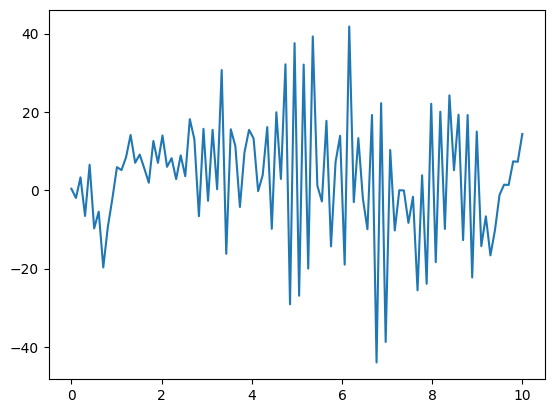

In [91]:
t_grid = jnp.linspace(0,10,100)
init_x = model.predict_state(t_grid,z0)
plt.plot(t_grid,init_x[:,0])